In [1]:
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns

### Configurações de pacotes

In [2]:
%matplotlib inline
np.set_printoptions(precision=4)
pd.set_option('max_colwidth', 180)

### Carga dos dados

In [3]:
colunas = ['id_ato', 'data_pub', 'tipo_ato', 'id_seg', 'tipo_seg', 'txt_seg']
df_seg = pd.read_csv('./dados/extracao-segmentos-atos.csv', delimiter='|', names=colunas, quotechar="'")

### Estrutura da fonte de dados

In [4]:
df_seg.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 206488 entries, 0 to 206487
Data columns (total 6 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   id_ato    206488 non-null  int64 
 1   data_pub  206488 non-null  object
 2   tipo_ato  206488 non-null  object
 3   id_seg    206488 non-null  int64 
 4   tipo_seg  206488 non-null  object
 5   txt_seg   204588 non-null  object
dtypes: int64(2), object(4)
memory usage: 9.5+ MB


In [5]:
print('Valores ausentes em {:5d} segmentos'.format(df_seg['txt_seg'].isna().sum()))

Valores ausentes em  1900 segmentos


#### Notas:
* 206.488 segmentos
* Valores ausentes em 1.900 segmentos
* txt_seg contém o texto dos segmentos a serem analisados
* tipo_seg é a variável alvo (classes)
* Demais atributos podem ser úteis para a análise exploratória

### Análise da quantidade de atos por tipo de ato

In [6]:
qtd_ato_por_tipo_ato = df_seg[['tipo_ato', 'id_ato']].groupby('tipo_ato')['id_ato'].nunique()
df_qtd_ato_por_tipo_ato = pd.DataFrame(qtd_ato_por_tipo_ato)
df_qtd_ato_por_tipo_ato.columns = ['qtd_ato']
df_qtd_ato_por_tipo_ato.reset_index(inplace=True)
df_qtd_ato_por_tipo_ato.sort_values(by='qtd_ato', ascending=False, inplace=True)

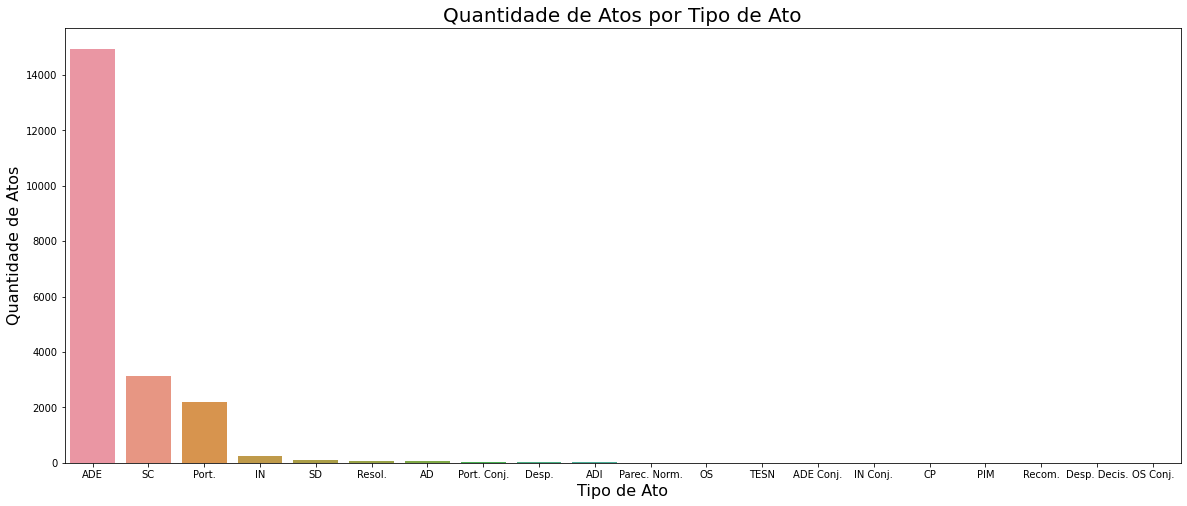

In [7]:
fig, ax = plt.subplots(figsize=(20,8))
sns.barplot(x='tipo_ato', y='qtd_ato', data=df_qtd_ato_por_tipo_ato)
ax.set_title('Quantidade de Atos por Tipo de Ato', fontsize=20)
ax.set_ylabel('Quantidade de Atos', fontsize=16)
ax.set_xlabel('Tipo de Ato', fontsize=16)
plt.show()

In [8]:
qtd_ato_ade = df_qtd_ato_por_tipo_ato[df_qtd_ato_por_tipo_ato['tipo_ato'] == 'ADE']['qtd_ato'].iloc[0]
qtd_total_ato = df_qtd_ato_por_tipo_ato['qtd_ato'].sum()
perc_ato_ade = qtd_ato_ade/qtd_total_ato
print('Quantidade de atos do tipo ADE: {:5d}'.format(qtd_ato_ade))
print('Quantidade total de atos: {:5d}'.format(qtd_total_ato))
print('Percentual de atos do tipo ADE: {:5.2f}%'.format(perc_ato_ade*100))

Quantidade de atos do tipo ADE: 14948
Quantidade total de atos: 20821
Percentual de atos do tipo ADE: 71.79%


#### Notas:
* Atos do tipo ADE representam mais 71.79% do total de atos 

### Análise da quantidade de segmentos por tipo de segmento

In [9]:
qtd_seg_por_tipo_seg = df_seg[['id_seg', 'tipo_seg']].groupby('tipo_seg').count().sort_values("id_seg", ascending=False)
qtd_seg_por_tipo_seg.columns = ['qtd_seg']
qtd_seg_por_tipo_seg.reset_index(inplace=True)

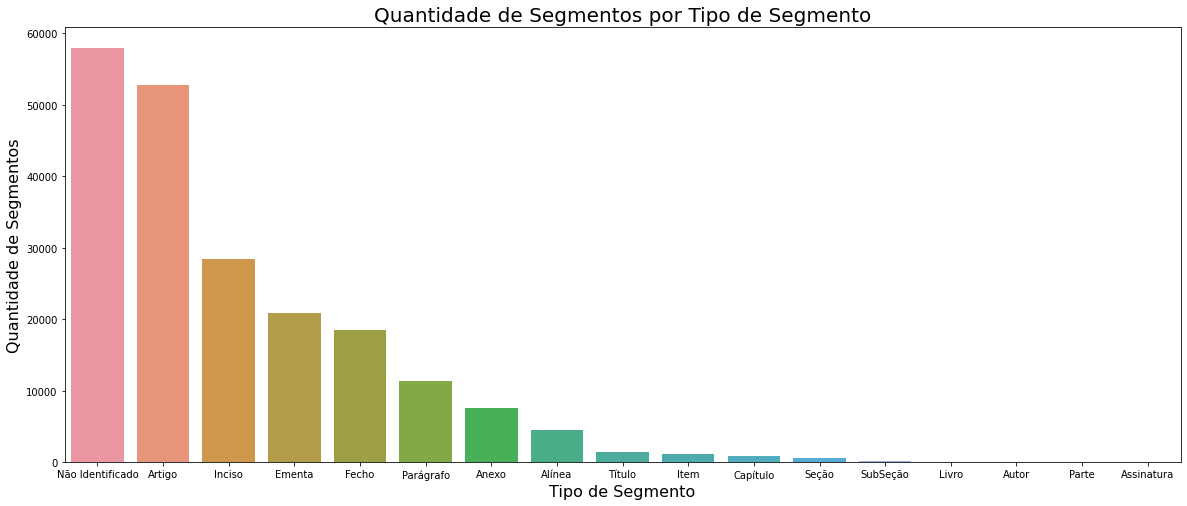

In [10]:
fig = plt.figure(figsize=(20,8))
ax = sns.barplot(x='tipo_seg', y='qtd_seg', data=qtd_seg_por_tipo_seg)
ax.set_title('Quantidade de Segmentos por Tipo de Segmento', fontsize=20)
ax.set_ylabel('Quantidade de Segmentos', fontsize=16)
ax.set_xlabel('Tipo de Segmento', fontsize=16)
plt.show()

In [11]:
qtd_seg_por_tipo_seg

,tipo_seg,qtd_seg
0,Não Identificado,57941
1,Artigo,52808
2,Inciso,28479
3,Ementa,20824
4,Fecho,18571
5,Parágrafo,11404
6,Anexo,7549
7,Alínea,4475
8,Título,1424
9,Item,1218


#### Notas:
* 17 classes
* Forte desbalanceamento entre as classes
* Algumas classes com pouca representatividade (poucas instâncias)
* Segmentos não identificados são maioria:
  * Omissão da classificação manual (segmento deveria ser de outra classe)?
  * A classe está sendo usada para alguma situação específica?
  * Segmentos que não precisam estar classificados em nenhuma outra classe?

## Análise considerando somente os atos do tipo ADE

### Carga dos dados considerando uma nova extração (somente atos ADE)

In [12]:
df_seg_ade = df_seg[df_seg['tipo_ato']=='ADE'] 

In [13]:
df_seg_ade.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 115040 entries, 277 to 206380
Data columns (total 6 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   id_ato    115040 non-null  int64 
 1   data_pub  115040 non-null  object
 2   tipo_ato  115040 non-null  object
 3   id_seg    115040 non-null  int64 
 4   tipo_seg  115040 non-null  object
 5   txt_seg   114418 non-null  object
dtypes: int64(2), object(4)
memory usage: 6.1+ MB


In [14]:
print('Valores ausentes em {:5d} segmentos.'.format(df_seg_ade['txt_seg'].isna().sum()))

Valores ausentes em   622 segmentos.


#### Notas:
* Redução do número de segmentos de 206.488 para 115.040
* Redução do número de atos de 20.821 para 14.948
* Redução dos valores ausentes de 1.900 para 622

### Tratamento de valores ausentes

In [15]:
total_seg_ade = df_seg_ade['id_seg'].count()
qtd_valores_ausentes = df_seg_ade['txt_seg'].isna().sum()
perc_valores_ausentes = qtd_valores_ausentes / total_seg_ade
print('Percentual de valores ausentes: {:5.2f}%'.format(perc_valores_ausentes*100))

Percentual de valores ausentes:  0.54%


#### Notas:
* Valores ausentes representam somente 0.54% dos valores de segmentos e podem ser excluídos.

In [16]:
# Exclusão de segmentos com valores ausentes
df_seg_ade=df_seg_ade[df_seg_ade['txt_seg'].notna()]

### Análise da quantidade de segmentos por tipo de segmento para atos ADE

In [17]:
qtd_seg_tipo_seg_ade = df_seg_ade[['id_seg', 'tipo_seg']].groupby('tipo_seg').count().sort_values("id_seg", ascending=False)
qtd_seg_tipo_seg_ade.columns = ['qtd_seg']
qtd_seg_tipo_seg_ade.reset_index(inplace=True)

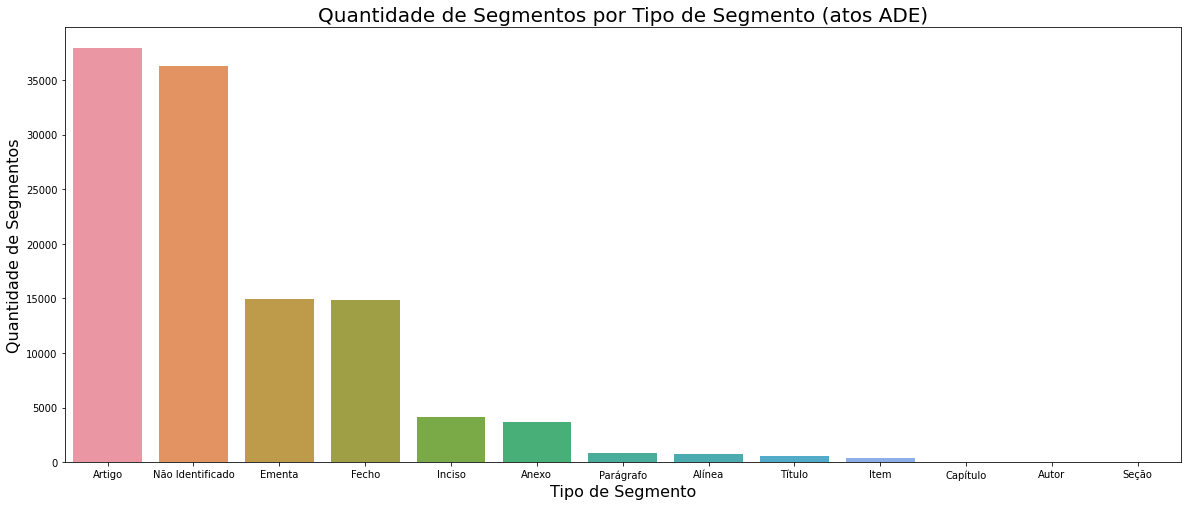

In [18]:
fig = plt.figure(figsize=(20,8))
ax = sns.barplot(x='tipo_seg', y='qtd_seg', data=qtd_seg_tipo_seg_ade)
ax.set_title('Quantidade de Segmentos por Tipo de Segmento (atos ADE)', fontsize=20)
ax.set_ylabel('Quantidade de Segmentos', fontsize=16)
ax.set_xlabel('Tipo de Segmento', fontsize=16)
plt.show()

In [19]:
qtd_seg_tipo_seg_ade

,tipo_seg,qtd_seg
0,Artigo,37921
1,Não Identificado,36288
2,Ementa,14948
3,Fecho,14853
4,Inciso,4134
5,Anexo,3679
6,Parágrafo,861
7,Alínea,780
8,Título,545
9,Item,398


### Análise da quantidade de atos (ADE) por tipo de segmento

In [20]:
qtd_ato_ade = df_seg_ade[['id_ato', 'tipo_seg']].groupby('tipo_seg')['id_ato'].nunique()
qtd_seg_tipo_seg_ade = qtd_seg_tipo_seg_ade.merge(qtd_ato_ade, how='inner', on='tipo_seg')
qtd_seg_tipo_seg_ade.rename(columns = {'id_ato':'qtd_ato'}, inplace=True)
qtd_seg_tipo_seg_ade

,tipo_seg,qtd_seg,qtd_ato
0,Artigo,37921,12679
1,Não Identificado,36288,14939
2,Ementa,14948,14948
3,Fecho,14853,14629
4,Inciso,4134,752
5,Anexo,3679,3242
6,Parágrafo,861,650
7,Alínea,780,144
8,Título,545,512
9,Item,398,163


### Comparando os resultados com todos os tipos de ato e somente com atos ADE

In [21]:
df_seg_comparativo = qtd_seg_por_tipo_seg.merge(qtd_seg_tipo_seg_ade, how='left', on='tipo_seg')
df_seg_comparativo = df_seg_comparativo.rename(columns = {'qtd_seg_x': 'qtd_seg', 'qtd_seg_y':'qtd_seg_ade'})

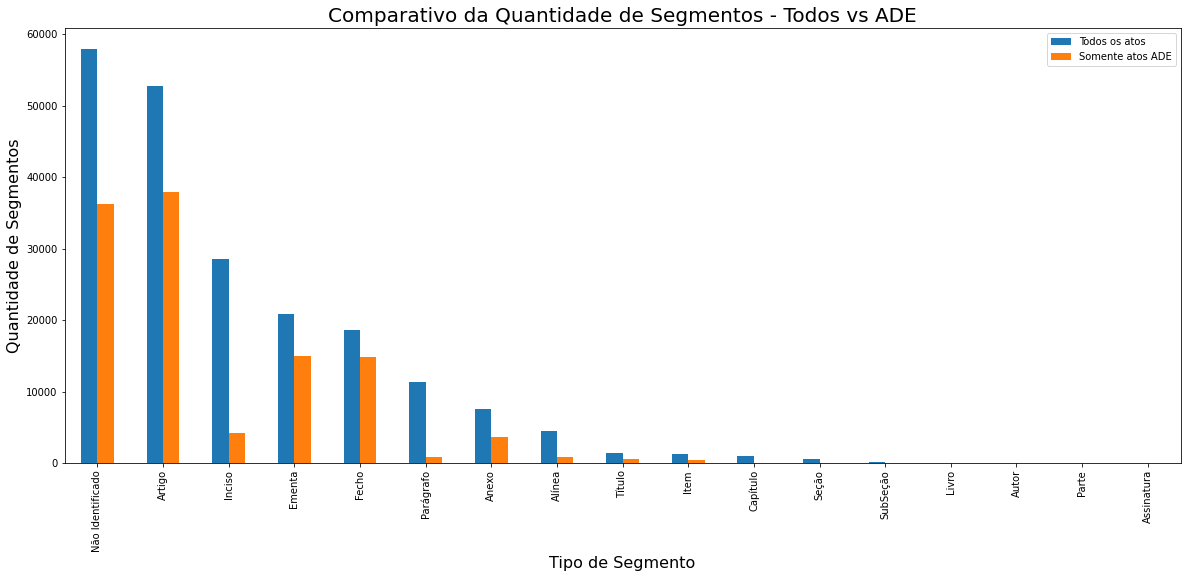

In [22]:
ax = df_seg_comparativo[['tipo_seg', 'qtd_seg', 'qtd_seg_ade']].plot(kind='bar', x='tipo_seg', figsize=(20,8))
ax.set_title('Comparativo da Quantidade de Segmentos - Todos vs ADE', fontsize=20)
ax.set_ylabel('Quantidade de Segmentos', fontsize=16)
ax.set_xlabel('Tipo de Segmento', fontsize=16)
ax.legend(['Todos os atos', 'Somente atos ADE'])
plt.show()

In [23]:
df_seg_comparativo

,tipo_seg,qtd_seg,qtd_seg_ade,qtd_ato
0,Não Identificado,57941,36288.0,14939.0
1,Artigo,52808,37921.0,12679.0
2,Inciso,28479,4134.0,752.0
3,Ementa,20824,14948.0,14948.0
4,Fecho,18571,14853.0,14629.0
5,Parágrafo,11404,861.0,650.0
6,Anexo,7549,3679.0,3242.0
7,Alínea,4475,780.0,144.0
8,Título,1424,545.0,512.0
9,Item,1218,398.0,163.0


#### Notas:
* Segmentos não identificados deixaram de ser majoritários, mas ainda carecem de uma avaliação mais detalhada
* As categorias Assinatura, Parte, Livro e Subseção não possuem segmento para atos ADE
* As categorias Parágrafo, Alínea, Título, Item, Capítuo, Autor e Seção ficaram com representatividade baixa (abaixo de 1%)

### Excluindo classes com pouca (<1%) ou nenhuma representatividade (NaN) em atos ADE

In [24]:
# Nenhuma representatividade
df_seg_comparativo.dropna(inplace=True)
df_seg_comparativo['qtd_seg_ade'] = df_seg_comparativo['qtd_seg_ade'].astype('int')

In [25]:
df_seg_comparativo['perc_seg_ade'] = df_seg_comparativo['qtd_seg_ade']/total_seg_ade

In [26]:
# Pouca representatividade
df_seg_comparativo = df_seg_comparativo[df_seg_comparativo['perc_seg_ade']>=0.01]

In [27]:
df_seg_comparativo = df_seg_comparativo.sort_values(by='qtd_seg_ade', ascending=False)

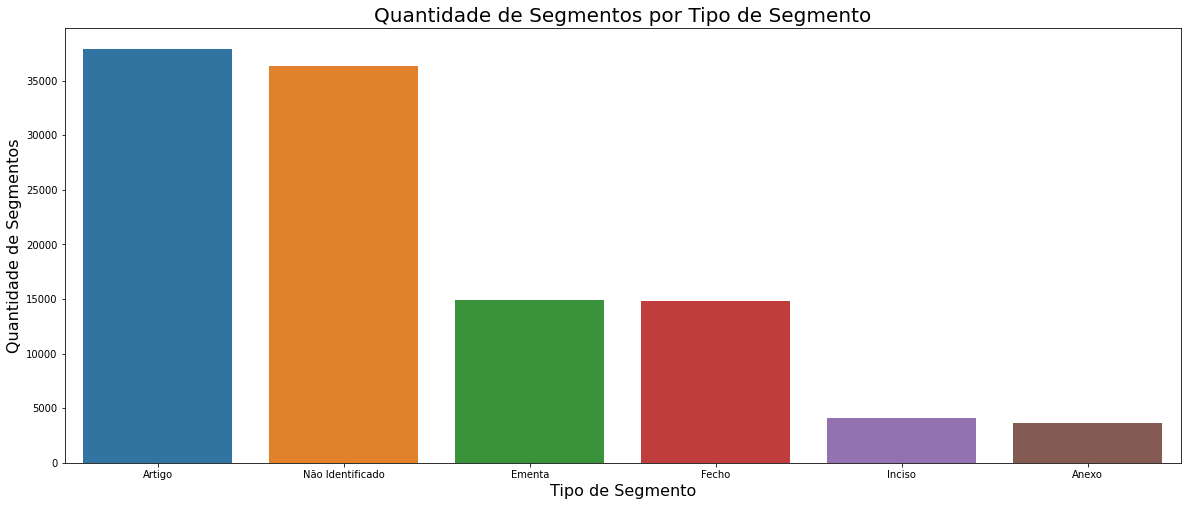

In [28]:
fig = plt.figure(figsize=(20,8))
ax = sns.barplot(x='tipo_seg', y='qtd_seg_ade', data=df_seg_comparativo)
ax.set_title('Quantidade de Segmentos por Tipo de Segmento', fontsize=20)
ax.set_ylabel('Quantidade de Segmentos', fontsize=16)
ax.set_xlabel('Tipo de Segmento', fontsize=16)
plt.show()

In [29]:
df_seg_comparativo

,tipo_seg,qtd_seg,qtd_seg_ade,qtd_ato,perc_seg_ade
1,Artigo,52808,37921,12679.0,0.329633
0,Não Identificado,57941,36288,14939.0,0.315438
3,Ementa,20824,14948,14948.0,0.129937
4,Fecho,18571,14853,14629.0,0.129112
2,Inciso,28479,4134,752.0,0.035935
6,Anexo,7549,3679,3242.0,0.031980


## Explorando os dados dos diferentes tipos de segmento

### Tipo: ARTIGO

In [30]:
df_seg_ade[df_seg_ade['tipo_seg']=='Artigo'][['id_ato','id_seg','txt_seg']].sample(15)

,id_ato,id_seg,txt_seg
8300,89875,1859873,"Art. 2&ordm; O recinto ora alfandegado est&aacute; sob a jurisdi&ccedil;&atilde;o da Alf&acirc;ndega do Porto de Santos, que baixar&aacute; as rotinas operacionais que se fizer..."
140502,105833,2079369,Art. 3º Este Ato Declaratório Executivo entra em vigor na data de sua publicação no Diário Oficial da União.
171976,111229,2161676,"Art. 1º. Habilitar a empresa abaixo identificada para operar no Regime Especial de Incentivos para o Desenvolvimento da Infraestrutura (REIDI), instituído pela Lei nº 11.488/20..."
69658,97268,1949369,Art. 2º - Este Ato Declaratório Executivo entra em vigor na data de sua publicação no DOU.
169898,110961,2158667,Art. 4º Este Ato Declaratório Executivo entra em vigor na data de sua publicação no Diário Oficial da União.
111164,102441,2003595,"Art. 3º - A presente habilitação poderá ser cancelada de ofício pela Autoridade Fiscal em caso de inobservância, por parte da beneficiária, de quaisquer dos requisitos que cond..."
202521,114304,2214289,Art. 7º Este Regime Especial não se aplica ao IPI devido no desembaraço aduaneiro de produtos de procedência estrangeira.
134655,104987,2069937,"Art. 4º Este ato declaratório somente terá validade, após a sua publicação no Diário Oficial da União."
195457,113686,2204824,"Art. 4&ordm; A pessoa jur&iacute;dica vendedora deve fazer constar, na nota fiscal de venda, a express&atilde;o &quot;venda efetuada com suspens&atilde;o da exig&ecirc;ncia da ..."
96589,100530,1985594,"Art. 1º Conceder à pessoa jurídica a seguir identificada a HABILITAÇÃO ao Regime de Suspensão da Contribuição para o PIS/Pasep e da Cofins nas aquisições de matérias-primas, pr..."


### Notas:
* Padrão "Art. <número ordinal>" (manter ou remover o ordinal?)
* Caracteres de escape HTML eventualmente aparece no lugar do ordinal (tratar HTML escapes na limpeza)
* Presença de nomes de entidades (empresas, órgãos, pessoas, leis, impostos, etc) - Considerar a utilização de NER

### Tipo: EMENTA

In [31]:
df_seg_ade[df_seg_ade['tipo_seg']=='Ementa'][['id_ato','id_seg','txt_seg']].sample(15)

,id_ato,id_seg,txt_seg
78941,98425,1961743,"Habilita a pessoa jurídica que menciona a operar no Regime Especial de Incentivos para o Desenvolvimento da Infra-Estrutura (Reidi), instituído pela Lei nº 11.488, de 15 de jun..."
195706,113727,2205169,Retificação
86964,99295,1971787,Anula inscrição no CPF.
193887,113541,2202595,"&quot;Disp&otilde;e sobre a libera&ccedil;&atilde;o, para fins de transfer&ecirc;ncia de propriedade, do ve&iacute;culo que menciona.&quot;"
154029,108165,2111212,Libera restrição de veículo importado que especifica.
157955,108728,2121541,"Reconhece o direito à redução do imposto de renda das pessoas jurídicas e adicionais não-restituíveis, incidentes sobre o lucro da exploração, relativo ao projeto de implantaçã..."
141534,105986,2081767,Concede regime especial de substituição tributária do IPI
9061,89935,1861009,"Declara habilitação no Regime Especial de Incentivos para o Desenvolvimento da Infra-Estrutura (REIDI), instituído pela Lei nº 11.488, de 15 de junho de 2007."
184121,112625,2187297,Concede coabilitação ao Regime Especial de Incentivos para o Desenvolvimento da Infra-Estrutura (Reidi) à empresa que menciona.
12257,90332,1866955,"Declara habilitada a utilizar o regime aduaneiro especial de utilização econômica destinado a bens a serem utilizados nas atividades de exploração, desenvolvimento e produção d..."


### Notas:
* Padrão "verbo" ou "substantivo" indicando ação (possível benefício do uso de POS-TAGGING)
* Aspas desnecessárias no início e no final de alguns segmentos (remover na limpeza)
* Caracteres de escape HTML (tratar HTML escapes na limpeza)
* Presença de nomes de entidades (empresas, órgãos, pessoas, leis, impostos, etc) - Considerar a utilização de NER 

### Tipo: FECHO

In [32]:
df_seg_ade[df_seg_ade['tipo_seg']=='Fecho'][['id_ato','id_seg','txt_seg']].sample(15)

,id_ato,id_seg,txt_seg
199959,114003,2210721,RICARDO PENALBER DE MENEZES PEREIRA&nbsp;
117830,103125,2011712,SEVERINO CAVALCANTE DE SOUZA
137025,105226,2073397,CLÁUDIO HENRIQUE GOMES DE OLIVEIRA
115593,102912,2009138,DANILO PIZOL INVERNIZZI
184413,112666,2188446,JOANA APARECIDA LAGES
186124,112929,2191832,ALTEMIR LINHARES DE MELO
126408,104306,2050272,JORDÃO NÓBRIGA DA SILVA JUNIOR
111540,102482,2004157,FÁBIO EDUARDO BOSCHI
40969,93736,1909428,OSMAR FABRE
110043,102297,2002345,DANILO PIZOL INVERNIZZI


In [33]:
# Segmentos preenchido com caractere ponto sozinho
regex = '^(\.)'
segs = df_seg_ade[df_seg_ade['tipo_seg']=='Fecho']
segs[segs['txt_seg'].str.contains(regex)]['id_seg'].count()

/home/91872936504/devx/saan/.env/lib/python3.6/site-packages/pandas/core/strings.py:2001: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


372

### Notas:
* Formado por nomes próprios em caixa alta
* Exceções:
  * 372 segmentos com caractere ponto sozinho (investigar)
  * Caracteres de escape HTML (tratar HTML escapes na limpeza)

### Tipo: INCISO

In [34]:
df_seg_ade[df_seg_ade['tipo_seg']=='Inciso'][['id_ato','txt_seg']].sample(15)

,id_ato,txt_seg
8107,89843,IX – Despacho de admissão na ZFM;
118782,103254,V - Processo Administrativo: 10480.721575/2019-86;
106960,101904,"II - Área da União localizada adjacente à área acima especificada e a Rua Benvenuto Taffarel e entre o Rio Uruguai, com área superficial de 3.478,22 m²."
105146,101613,IV - Percentual de redução do Imposto de Renda das Pessoas Jurídicas e adicionais não restituíveis: 75% (setenta e cinco por cento);
9064,89935,"II – Vincular o presente ADE ao projeto constante do Anexo da Portaria nº 308, de 17 de outubro de 2017, da Secretaria de Planejamento e Desenvolvimento Energético do Ministéri..."
89918,99680,"VI – Setor prioritário considerado: Indústria de Transformação – Químicos, Decreto 4.213, art. 2º, inciso VI, alínea e;"
6040,89586,"VII - despacho para admissão em outros regimes aduaneiros especiais, na importação ou na exportação;"
100930,101047,"II - Carga, descarga, transbordo, baldeação, redestinação, armazenagem ou passagem de mercadorias ou bens procedentes do exterior ou a ele destinadas;"
85854,99156,"IV – Fundamento legal para reconhecimento do direito: art. 1º da Medida Provisória nº 2.199-14, de 24 de agosto de 2001, em conformidade com o estabelecido no Decreto nº 4.213..."
152669,107994,"IV - Serviço Incentivado: Captação, tratamento e distribuição de água;"


### Notas:
* Padrão "número em romano - ..."
* Presença de nomes de entidades (empresas, órgãos, pessoas, leis, impostos, etc) - Considerar a utilização de NER 

### Tipo: ANEXO

In [35]:
df_seg_ade[df_seg_ade['tipo_seg']=='Anexo'][['id_ato','txt_seg']].sample(15)

,id_ato,txt_seg
51628,95144,a
138101,105385,a
58915,96028,a
45503,94351,a
108238,102069,a
59608,96134,a
58972,96037,a
26736,92026,a
143938,106312,a
159908,109022,a


In [36]:
df_seg_ade[df_seg_ade['tipo_seg']=='Anexo']['txt_seg'].unique()

array(['Novo segmento', 'a', '&nbsp;', '.', ' ', 'A', 'Anexo .html', '.a',
       'a ', 'Art. 1&ordm;', 'Art. 1&deg;', 'Anexo  .html', 'tab1',
       'art. 2&ordm;', 'art. 3&ordm;', 'art. 1º', 'anexo &uacute;nico.',
       'art. 2º', 'art. 3º', 'anexo único', 'art. 1&ordm;', 'art, 1º',
       '1.', '2.', 'Art. 2&ordm;', 'Art. 3&ordm;',
       'Hakushu 12 Y\tCaixas com 06 garrafas de 750 ml, 43% GL\t126',
       'Anexo &Uacute;nico', 'Tabela', 'Art. 2&deg;', 'Art. 3&deg;'],
      dtype=object)

### Notas:
* Os textos dos segmentos do tipo Anexo não possuem relação com o conteúdo do anexo. Como o anexo é armazenado como um arquivo binário, os textos dos segmentos não possuem valor para a classificação do segmento. 
* Por conta dessa característica específica, o tipo de segmento Anexo não será considerado no escopo da classificação. 

In [37]:
# Exclusão dos segmentos do tipo Anexo
df_seg_comparativo = df_seg_comparativo[df_seg_comparativo['tipo_seg']!='Anexo']

### Tipo: NÃO IDENTIFICADO

In [38]:
segs = df_seg_ade[df_seg_ade['tipo_seg']=='Não Identificado'][['id_seg','txt_seg']]
#segs.sample(15)
segs.count()

id_seg     36288
txt_seg    36288
dtype: int64

In [39]:
# Padrão com 4 ou mais caracteres de ponto em qualquer trecho do segmento
regex = '(\.{4,})'
segs[segs['txt_seg'].str.contains(regex)].count()['id_seg']

/home/91872936504/devx/saan/.env/lib/python3.6/site-packages/pandas/core/strings.py:2001: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


71

In [40]:
# Padrão iniciando com qualquer quantidade de espaços seguidos de 'Art' e depois ponto ou espaço
regex = '^(\s{0,})Art[\s\.]'
segs[segs['txt_seg'].str.contains(regex)].count()['id_seg']

1414

### Notas:
* Encontrados 71 segmentos formados por grande quantidade de pontos. Como a quantidade foi muito pequena, se comparada ao total de segmentos dessa classe (36.288), esses segmentos serão mantidos (inicialmente como segmentos válidos para a classe).
* Encontrados 1.414 segmentos (3,9% do total) com padrões de texto parecidos com artigos. Foi realizada uma inspeção de alguns atos desse conjunto e a hipótese mais provável é de omissão de classificação. Esses segmentos serão reclassificados durante a etapa de limpeza.
* Não foram encontrados outros padrões e foi assumido que os demais 34.874 segmentos (96,1%) serão considerados como não identificados (válidos para classe em questão). 


### Comparando a quantidade final de segmentos

In [41]:
tipo_seg_mantidos = ['Não Identificado', 'Artigo', 'Ementa', 'Fecho', 'Inciso']
df_seg_ade_mantidos = df_seg_ade[df_seg_ade['tipo_seg'].isin(tipo_seg_mantidos)]
perc_seg_mantidos = df_seg_ade_mantidos['id_seg'].count() / df_seg_ade['id_seg'].count()
print('Total de segmentos em atos ADE: {:5d}'.format(df_seg_ade['id_seg'].count()))
print('Total de segmentos mantidos (após o tratamento) em atos ADE: {:5d}'.format(df_seg_ade_mantidos['id_seg'].count()))
print('Percentual de segmentos mantidos (após o tratamento) em atos ADE: {:5.2f}%'.format(perc_seg_mantidos*100))
print('Valores ausentes nos segmentos mantidos: {:5d}'.format(df_seg_ade_mantidos['txt_seg'].isna().sum()))

Total de segmentos em atos ADE: 114418
Total de segmentos mantidos (após o tratamento) em atos ADE: 108144
Percentual de segmentos mantidos (após o tratamento) em atos ADE: 94.52%
Valores ausentes nos segmentos mantidos:     0


## Conclusões
* Sobre a redução do escopo de dados para os atos do tipo ADE:
  * Permitiu a diminuição do número de tipos de segmentos a serem considerados no treinamento do modelo de classificação (de 17 para 6 tipos);
  * As perdas para o modelo tendem a ser mínimas porque foram removidas somente tipos de segmento sem representatividade ou com representatividade abaixo de 1%;
  * Somados os segmentos dos tipos removidas representam menos de 6% de todos os segmentos em atos ADE (94.52% dos segmentos foram mantidos).
* O escopo de dados permanece significativo já que os atos ADE representam 71.79% do total de atos.
* Sobre os segmentos do tipo Não Identificado:
  * 1.414 segmentos não foram classificados manualmente (assumindo falha humana por omissão na classificação manual) e serão reclassificados como Artigo, devido ao padrão encontrado nos textos desses segmentos.
  * Os demais segmentos permanecerão pertencendo ao tipo Não Identificado.
* Foram encontrados caracteres de escape HTML em segmentos de alguns tipos. O tratamento desses caracteres será considerado na etapa de limpeza de dados.
* O tipo Anexo será desconsiderado por não se tratar de conteúdo textual válido.
* Os 5 tipos restantes estão desbalanceados e um tratamento específico será necessário na etapa de pre-processamento.
* Foram encontrados valores ausentes nos segmentos, mas representavam somente 0.54% dos valores de segmentos e foram excluídos.
